# Variable Reduction
Here we are taking a look at a straightforward variable reduction technique, specifically focusing on using XGBoost.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

This dataset comes from the following kaggle competition:
https://www.kaggle.com/c/home-credit-default-risk  
The `target` field we will be predicting is if a person will default on their housing loan, or not.

In [2]:
df_full = pd.read_parquet("data/application_train_proc.parquet")

I have already done some prep work to the data, creating encoded object fields, and removing a few records. I could would definitely do more feature engineering if I was looking to maximize performance, but for now we are just using this dataset as a way to test feature reduction.

In [3]:
df_full.shape

(307507, 136)

In [4]:
df_full.dtypes.value_counts()

float64    70
int64      41
object     16
int8        9
dtype: int64

Drop `object` columns and convert data to `np.float32` to keeps things consistent for XGBoost modeling.

In [5]:
drop_cols = df_full.dtypes.pipe(lambda x: x[x.eq("object")]).index
df = df_full.drop(columns=drop_cols)
# For now we will just start off testing with a sample of the data to speed things up.
df = df.sample(200_000, random_state=123)

In [6]:
df.shape

(200000, 120)

We are going to split our data into a development, testing, and then hold out validation sample.

In [7]:
np.random.seed(123)
rand_num = np.random.uniform(size=df.shape[0])
dev = rand_num < 0.5
val = (0.5 <= rand_num) & (rand_num < 0.75)
tst = 0.75 <= rand_num

In [8]:
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

We we create out `xgboost.DMatrix` objects, these are the data types that are required to use the XGBoost Learning API.

In [9]:
xdev = xgb.DMatrix(X[dev], label=y[dev], missing=np.nan)
xtst = xgb.DMatrix(X[tst], label=y[tst], missing=np.nan)
xval = xgb.DMatrix(X[val], label=y[val], missing=np.nan)

### Training a Baseline Model Optimized with `scikit-optimize`
First we will train a baseline model, and we will use bayesian optimization through the `scikit-optimize` package with the `gp_minimize` function.  
The following will be our "base" set of parameters.  
```python
params = dict(
    objective="binary:logitraw",
    eta=0.1,
    max_depth=0,
    min_child_weight=50,
    max_leaves=35,
    tree_method="hist",
    grow_policy="lossguide",
    subsample=0.8,
    colsample_bytree=0.50,
    eval_metric="auc",
    seed=0,
)
```
We will optimize the following XGBoost parameters.  
- `eta`
- `min_child_weight`
- `max_leaves`
- `subsample`
- `colsample_bytree`

In [44]:
unopt_params = dict(
    objective="binary:logitraw",
    eta=0.1,
    max_depth=0,
    min_child_weight=50,
    max_leaves=35,
    tree_method="hist",
    grow_policy="lossguide",
    subsample=0.8,
    colsample_bytree=0.50,
    eval_metric="auc",
    seed=0,
)

In [45]:
unopt_watchlist = [(xdev, "dev"), (xtst, "test")]

In [46]:
unopt_mod = xgb.train(
    params=unopt_params,
    dtrain=xdev,
    num_boost_round=1_000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=100,
)

[0]	dev-auc:0.69588	test-auc:0.67668
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[100]	dev-auc:0.81709	test-auc:0.74525
Stopping. Best iteration:
[102]	dev-auc:0.81819	test-auc:0.74540



In [10]:
xgb_search_space = [
    Real(0.05, 0.2, name="eta"),
    Integer(50, 200, name="min_child_weight"),
    Integer(15, 35, name="max_leaves"),
    Real(0.5, 1.0, name="subsample"),
    Real(0.5, 1.0, name="colsample_bytree"),
]

Next we have to set up the function we want to minimize, in our case, it will be the cross validation performance of the model on our development dataset.

In [11]:
# These are our constant parameters, that will remain unchanged through
# all of modeling.
base_params = dict(
    objective="binary:logitraw",
    max_depth=0,
    tree_method="hist",
    grow_policy="lossguide",
    eval_metric="auc",
    seed=123,
)


@use_named_args(xgb_search_space)
def xgb_obj_func(**points):
    mod_points = {**points, **base_params}
    # We will use cross-validation performance to test
    # the parameters. We will let XGBoost deal with the
    # early stopping rounds itself.
    mod_cv = xgb.cv(
        params=mod_points,
        dtrain=xdev,
        num_boost_round=1_000,
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    best_cv = mod_cv.loc[mod_cv["test-auc-mean"].idxmax()]
    best_score = -best_cv["test-auc-mean"]
    best_cv = best_cv.round(4)
    print(
        f"train-auc: {best_cv['train-auc-mean']}, "
        + f"test-auc: {best_cv['test-auc-mean']}, "
        + f"iterations: {mod_cv.shape[0]}"
    )
    return best_score

We optimize our objective function using the `gp_minimize` function from scikit-optimize.

In [12]:
bayes_params = gp_minimize(
    xgb_obj_func,
    xgb_search_space,
    n_calls=35,
    # Our initial points.
    # [eta=0.1, min_child_weight=50, max_leaves=35, subsample=0.8, colsample_bytree=0.50,]
    x0=[0.1, 50, 35, 0.8, 0.50,],
    random_state=0,
)

train-auc: 0.8071, test-auc: 0.7513, iterations: 64
train-auc: 0.8038, test-auc: 0.7527, iterations: 85
train-auc: 0.7953, test-auc: 0.7523, iterations: 98
train-auc: 0.8014, test-auc: 0.7515, iterations: 54
train-auc: 0.7905, test-auc: 0.7509, iterations: 52
train-auc: 0.804, test-auc: 0.7538, iterations: 104
train-auc: 0.8051, test-auc: 0.7521, iterations: 128
train-auc: 0.7909, test-auc: 0.7529, iterations: 179
train-auc: 0.8067, test-auc: 0.7536, iterations: 122
train-auc: 0.7964, test-auc: 0.7532, iterations: 77
train-auc: 0.8074, test-auc: 0.7533, iterations: 115
train-auc: 0.8034, test-auc: 0.7545, iterations: 247
train-auc: 0.8045, test-auc: 0.7542, iterations: 331
train-auc: 0.7746, test-auc: 0.7491, iterations: 59
train-auc: 0.8125, test-auc: 0.7529, iterations: 199
train-auc: 0.8042, test-auc: 0.7494, iterations: 51
train-auc: 0.7884, test-auc: 0.7533, iterations: 166
train-auc: 0.7986, test-auc: 0.7513, iterations: 55
train-auc: 0.811, test-auc: 0.7539, iterations: 215
trai

Now we will take the best parameters from this optimization and train a model.

In [13]:
best_bayes_params = np.argmin(bayes_params.func_vals)
best_bayes_params = {
    s.name: p for s, p in zip(xgb_search_space, bayes_params.x_iters[best_bayes_params])
}
np.argmin(bayes_params.func_vals)

27

In [14]:
best_bayes_params = {**base_params, **best_bayes_params}
best_bayes_params

{'objective': 'binary:logitraw',
 'max_depth': 0,
 'tree_method': 'hist',
 'grow_policy': 'lossguide',
 'eval_metric': 'auc',
 'seed': 123,
 'eta': 0.051272107358498985,
 'min_child_weight': 184,
 'max_leaves': 33,
 'subsample': 0.7089763430499714,
 'colsample_bytree': 0.5021842771568298}

In [15]:
watchlist = [(xdev, "dev"), (xtst, "test")]

In [16]:
base_mod = xgb.train(
    params=best_bayes_params,
    dtrain=xdev,
    num_boost_round=1_000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=100,
)

[0]	dev-auc:0.72030	test-auc:0.70554
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[100]	dev-auc:0.77136	test-auc:0.74173
[200]	dev-auc:0.78793	test-auc:0.74730
[300]	dev-auc:0.80010	test-auc:0.74740
Stopping. Best iteration:
[270]	dev-auc:0.79660	test-auc:0.74768



Let's check performance on our dev, test, and val datasets.

In [17]:
base_dev_preds = base_mod.predict(xdev, ntree_limit=base_mod.best_ntree_limit)
base_tst_preds = base_mod.predict(xtst, ntree_limit=base_mod.best_ntree_limit)
base_val_preds = base_mod.predict(xval, ntree_limit=base_mod.best_ntree_limit)

In [47]:
unopt_dev_preds = unopt_mod.predict(xdev, ntree_limit=unopt_mod.best_ntree_limit)
unopt_tst_preds = unopt_mod.predict(xtst, ntree_limit=unopt_mod.best_ntree_limit)
unopt_val_preds = unopt_mod.predict(xval, ntree_limit=unopt_mod.best_ntree_limit)

In [48]:
print(
    f"dev auc: {roc_auc_score(y[dev], unopt_dev_preds)}\n"
    + f"tst auc: {roc_auc_score(y[tst], unopt_tst_preds)}\n"
    + f"val auc: {roc_auc_score(y[val], unopt_val_preds)}\n"
)

dev auc: 0.8181890388883102
tst auc: 0.7454051947047909
val auc: 0.7537540433815373



In [18]:
print(
    f"dev auc: {roc_auc_score(y[dev], base_dev_preds)}\n"
    + f"tst auc: {roc_auc_score(y[tst], base_tst_preds)}\n"
    + f"val auc: {roc_auc_score(y[val], base_val_preds)}\n"
)

dev auc: 0.7966043153556779
tst auc: 0.7476844910625849
val auc: 0.7541903489192988



Often in credit risk scenarios KS statistic is used to calculate the performance of the model.

In [19]:
def calc_ks_groupby(y_true, y_score, ascending=False, decimal: int = None):
    sdf = pd.DataFrame({"y_true": y_true, "y_score": y_score})
    if decimal is not None:
        sdf["y_score"] = sdf["y_score"].round(decimal)
    if not ascending:
        sdf["y_score"] = sdf["y_score"].mul(-1)

    # Not using lambda functions seems to speed things up substantially.
    sdf_g = sdf.groupby("y_score", sort=True).agg(
        sum_1=("y_true", "sum"), sum_0=("y_true", "count"),
    )
    sdf_g["sum_0"] = sdf_g["sum_0"] - sdf_g["sum_1"]

    sdf_g["cumlp_1"] = sdf_g["sum_1"].cumsum() / sdf_g["sum_1"].sum()
    sdf_g["cumlp_0"] = sdf_g["sum_0"].cumsum() / sdf_g["sum_0"].sum()
    diff_1_0 = sdf_g["cumlp_1"] - sdf_g["cumlp_0"]
    max_sep = np.argmax(np.abs(diff_1_0))
    return diff_1_0.iat[max_sep]


def calc_ks(y_true, y_score, ascending=False):
    """Calculate KS, if I was using a classic 3 digit credit score,
    I would want to use groupby instead.
    """
    data = pd.DataFrame({"y_true": y_true, "y_score": y_score})
    scr_dat = data.sort_values("y_score", ascending=ascending)
    tot_perf = scr_dat["y_true"].sum()
    cuml_gd = scr_dat["y_true"].eq(0).cumsum() / scr_dat["y_true"].eq(0).sum()
    cuml_bd = scr_dat["y_true"].eq(1).cumsum() / scr_dat["y_true"].sum()
    return (cuml_bd - cuml_gd).max()

In [20]:
%%timeit
calc_ks_groupby(y[dev], base_dev_preds)

27.2 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
calc_ks(y[dev], base_dev_preds)

11.9 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
print(
    f"dev KS: {calc_ks_groupby(y[dev], base_dev_preds)}\n"
    + f"tst KS: {calc_ks_groupby(y[tst], base_tst_preds)}\n"
    + f"val KS: {calc_ks_groupby(y[val], base_val_preds)}\n"
)

dev KS: 0.4480633693645598
tst KS: 0.36461364603833224
val KS: 0.38115138000594323



In [23]:
print(
    f"dev KS: {calc_ks(y[dev], base_dev_preds)}\n"
    + f"tst KS: {calc_ks(y[tst], base_tst_preds)}\n"
    + f"val KS: {calc_ks(y[val], base_val_preds)}\n"
)

dev KS: 0.44806338198376106
tst KS: 0.3646136261701173
val KS: 0.3811513834845193



In [49]:
print(
    f"dev KS: {calc_ks(y[dev], unopt_dev_preds)}\n"
    + f"tst KS: {calc_ks(y[tst], unopt_tst_preds)}\n"
    + f"val KS: {calc_ks(y[val], unopt_val_preds)}\n"
)

dev KS: 0.48526510016076907
tst KS: 0.357103395630423
val KS: 0.3786981512992897



#### Taking a Look at the Top Attributes

Let's take a look at some of the important variables in the model.

In [24]:
base_var_imp = pd.Series(
    base_mod.get_score(importance_type="gain"), name="gain",
).sort_values(ascending=False)
base_var_imp_norm = base_var_imp.div(base_var_imp.sum())

How many attributes didn't make it into the model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

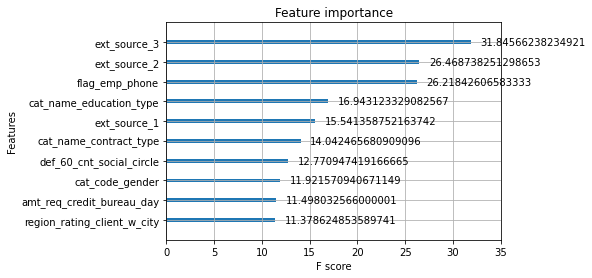

In [25]:
xgb.plot_importance(base_mod, importance_type="gain", max_num_features=10)

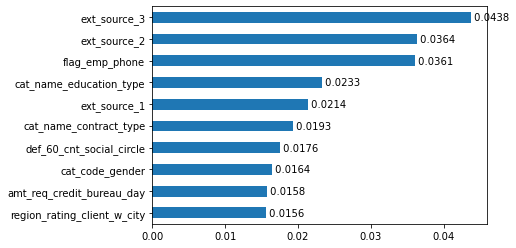

In [26]:
import matplotlib.pyplot as plt

top_10_vars_bi = base_var_imp_norm.head(10).sort_values()
p1 = top_10_vars_bi.plot.barh()
for i, v in enumerate(top_10_vars_bi.round(4)):
    plt.text(v, i, " " + str(v), color="black", va="center")
plt.show()

### Exploring Recursive Feature Elimination
I looked into the scikit-learn classes `RFE` and `RFECV` but it doesn't let you pass any parameters into fit, so I can't set all of the parameters I need...

In [27]:
[0, 1, 2, 3][:-2]

[0, 1]

In [28]:
0.05 * 100

5.0

In [29]:
import warnings
from dataclasses import dataclass
from typing import Dict, Optional, Union


@dataclass
class FoldBlock:
    train_data: Dict[str, Union[pd.DataFrame, Union[pd.Series, np.array]]]
    test_data: Dict[str, Union[pd.DataFrame, Union[pd.Series, np.array]]]


def calc_step(n_features, step):
    """Calculate the lenght of the step
    """
    if step >= 1:
        return step
    else:
        step = int(n_features * step)
        step = 1 if step == 0 else step
        return step


def recurisve_elmination_xgb_cv(
    params: dict,
    X: pd.DataFrame,
    y: Union[pd.Series, np.array],
    dtrain_args: Optional[dict] = None,
    n_features_to_select: Optional[int] = None,
    step: int = 1,
    nfold: int = 3,
    importance_type: str = "gain",
    early_stopping_rounds: int = 50,
    num_boost_round: int = 10,
    verbose: bool = True,
    as_pandas: bool = True,
    seed: int = 0,
):
    """Recursive feature elimination using cross validation, the dataset will
    be split into nfold, and each fold will be used seperatly to test the model for
    early stopping rounds, while the remaining portion of the data will be used to
    train a model.
    The first iteration may drop a large number of columns, if there are a lot of
    columns with an importance metric value of 0.
    """
    feature_names = X.columns
    # Use half of the features if a number isn't specified
    if n_features_to_select is None:
        n_features_to_select = len(feature_names) // 2

    assert isinstance(X, pd.DataFrame), "X must be a pandas DataFrame."
    assert nfold > 1, "nfold must be greater than 1"

    # Create the CV folds.
    # - We randomly create a shuffled index of the data
    # - That gets split into nfold
    # - The out of fold data (oo_fold_idx) is each of these
    #   seperate folds.
    # - The infold, is all other folds combined, these will be used
    #   for the training dataset.
    np.random.seed(seed)
    rand_idx = np.random.permutation(X.shape[0])
    oo_fold_idx = np.array_split(rand_idx, nfold)
    in_fold_idx = [
        np.concatenate([oo_fold_idx[i] for i in range(nfold) if i != k])
        for k in range(nfold)
    ]

    fold_data = []
    for i in range(nfold):
        fold_block = FoldBlock(
            train_data={"X": X.iloc[in_fold_idx[i]], "y": y.iloc[in_fold_idx[i]]},
            test_data={"X": X.iloc[oo_fold_idx[i]], "y": y.iloc[oo_fold_idx[i]]},
        )
        fold_data.append(fold_block)

    select_cycle = 0
    final_results = {}
    while len(feature_names) > n_features_to_select:
        # if "evals_result" in kwargs:
        #     warnings.warn("The parameter evals_result will be ignored")
        #     del kwargs["evals_result"]
        cv_results = {}
        for i, block in enumerate(fold_data):
            cv_results[i] = {}
            e_results = {}
            # Subset down to modeling columns
            block.train_data["X"] = block.train_data["X"][feature_names]
            block.test_data["X"] = block.test_data["X"][feature_names]

            if dtrain_args is None:
                dtrain = xgb.DMatrix(block.train_data["X"], label=block.train_data["y"])
                dtest = xgb.DMatrix(block.test_data["X"], label=block.test_data["y"])
            else:
                dtrain = xgb.DMatrix(
                    block.train_data["X"], label=block.train_data["y"], **dtrain_args
                )
                dtest = xgb.DMatrix(
                    block.test_data["X"], label=block.test_data["y"], **dtrain_args
                )

            watchlist = [(dtrain, "train"), (dtest, "test")]

            # Train model for the fold.
            rfe_mod = xgb.train(
                params=params,
                dtrain=dtrain,
                evals_result=e_results,
                evals=watchlist,
                num_boost_round=num_boost_round,
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=False,
            )

            # Get model perf info.
            eval_m = sorted(list(e_results["train"].keys()))[0]
            cv_results[i][f"train_{eval_m}"] = e_results["train"][eval_m][
                rfe_mod.best_iteration
            ]
            cv_results[i][f"test_{eval_m}"] = e_results["test"][eval_m][
                rfe_mod.best_iteration
            ]
            # Get variable importance and normalize
            cv_results[i]["variable_imp"] = pd.Series(
                rfe_mod.get_score(importance_type=importance_type)
            ).pipe(lambda x: x.div(x.sum()))

        # Summarize results over folds.
        final_results[select_cycle] = {}
        final_results[select_cycle][f"mean_train_{eval_m}"] = np.mean(
            [cv_results[f][f"train_{eval_m}"] for f in cv_results]
        )
        final_results[select_cycle][f"mean_test_{eval_m}"] = np.mean(
            [cv_results[f][f"test_{eval_m}"] for f in cv_results]
        )
        # Get the average variable importance accross all folds.
        avg_fold_imp = (
            pd.concat([cv_results[f]["variable_imp"] for f in cv_results], axis=1)
            .fillna(0)
            .mean(axis=1)
            .sort_values(ascending=False)
        )
        n_features = avg_fold_imp.shape[0]
        fold_features = avg_fold_imp.index.to_list()
        final_results[select_cycle]["n_features"] = n_features
        final_results[select_cycle]["variables"] = fold_features
        feature_names = fold_features[: -calc_step(n_features, step)]
        if verbose:
            train_message = f"mean_train_{eval_m}"
            test_message = f"mean_test_{eval_m}"
            print(
                f"[{(str(select_cycle)+']').ljust(7)}"
                + f"{train_message}: {final_results[select_cycle][train_message]:.5f}  "
                + f"{test_message}: {final_results[select_cycle][test_message]:.5f}  "
                + f"num-features: {n_features}"
            )
        if len(feature_names) == 0:
            break
        select_cycle += 1

    if as_pandas:
        final_results = pd.DataFrame.from_dict(final_results, orient="index")

    return final_results

In [30]:
test_rfe = recurisve_elmination_xgb_cv(
    params=best_bayes_params,
    X=X[dev],
    y=y[dev],
    dtrain_args={"missing": np.nan},
    n_features_to_select=10,
    step=5,
    nfold=3,
    importance_type="gain",
    early_stopping_rounds=30,
    num_boost_round=1_000,
    verbose=True,
    seed=0,
)

[0]     mean_train_auc: 0.79178  mean_test_auc: 0.75439  num-features: 97
[1]     mean_train_auc: 0.79328  mean_test_auc: 0.75484  num-features: 92
[2]     mean_train_auc: 0.79560  mean_test_auc: 0.75413  num-features: 87
[3]     mean_train_auc: 0.79222  mean_test_auc: 0.75443  num-features: 82
[4]     mean_train_auc: 0.79826  mean_test_auc: 0.75443  num-features: 77
[5]     mean_train_auc: 0.79255  mean_test_auc: 0.75548  num-features: 72
[6]     mean_train_auc: 0.79344  mean_test_auc: 0.75500  num-features: 67
[7]     mean_train_auc: 0.79001  mean_test_auc: 0.75493  num-features: 62
[8]     mean_train_auc: 0.79286  mean_test_auc: 0.75531  num-features: 57
[9]     mean_train_auc: 0.78691  mean_test_auc: 0.75474  num-features: 52
[10]    mean_train_auc: 0.79177  mean_test_auc: 0.75508  num-features: 47
[11]    mean_train_auc: 0.79002  mean_test_auc: 0.75537  num-features: 42
[12]    mean_train_auc: 0.78770  mean_test_auc: 0.75579  num-features: 37
[13]    mean_train_auc: 0.78850  mean_

In [31]:
import seaborn as sns

<AxesSubplot:xlabel='n_features', ylabel='mean_test_auc'>

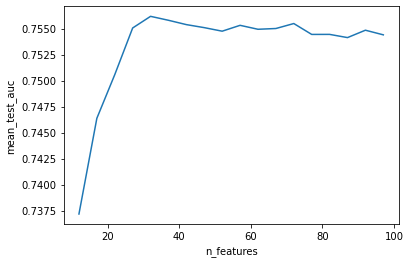

In [32]:
sns.lineplot(x="n_features", y="mean_test_auc", data=test_rfe)

In [33]:
best_n_features = test_rfe["mean_test_auc"].idxmax()
best_n_features

13

In [34]:
xdev_slim = xgb.DMatrix(
    X[dev][test_rfe.iat[best_n_features, 3]], label=y[dev], missing=np.nan
)
xtst_slim = xgb.DMatrix(
    X[tst][test_rfe.iat[best_n_features, 3]], label=y[tst], missing=np.nan
)
xval_slim = xgb.DMatrix(
    X[val][test_rfe.iat[best_n_features, 3]], label=y[val], missing=np.nan
)

In [35]:
watchlist_slim = [(xdev_slim, "dev"), (xtst_slim, "tst")]

In [36]:
slim_mod = xgb.train(
    params=best_bayes_params,
    dtrain=xdev_slim,
    num_boost_round=1_000,
    early_stopping_rounds=50,
    evals=watchlist_slim,
    verbose_eval=100,
)

[0]	dev-auc:0.69083	tst-auc:0.67458
Multiple eval metrics have been passed: 'tst-auc' will be used for early stopping.

Will train until tst-auc hasn't improved in 50 rounds.
[100]	dev-auc:0.76834	tst-auc:0.74183
[200]	dev-auc:0.78234	tst-auc:0.74735
[300]	dev-auc:0.79158	tst-auc:0.74842
[400]	dev-auc:0.79906	tst-auc:0.74858
Stopping. Best iteration:
[365]	dev-auc:0.79643	tst-auc:0.74881



In [37]:
slim_dev_preds = slim_mod.predict(xdev_slim, ntree_limit=slim_mod.best_ntree_limit)
slim_tst_preds = slim_mod.predict(xtst_slim, ntree_limit=slim_mod.best_ntree_limit)
slim_val_preds = slim_mod.predict(xval_slim, ntree_limit=slim_mod.best_ntree_limit)

In [38]:
print(
    f"dev KS: {calc_ks(y[dev], slim_dev_preds)}\n"
    + f"tst KS: {calc_ks(y[tst], slim_tst_preds)}\n"
    + f"val KS: {calc_ks(y[val], slim_val_preds)}\n"
)

dev KS: 0.44654275239329255
tst KS: 0.37061875199693234
val KS: 0.38369467830941506



In [39]:
print(
    f"dev KS: {calc_ks(y[dev], base_dev_preds)}\n"
    + f"tst KS: {calc_ks(y[tst], base_tst_preds)}\n"
    + f"val KS: {calc_ks(y[val], base_val_preds)}\n"
)

dev KS: 0.44806338198376106
tst KS: 0.3646136261701173
val KS: 0.3811513834845193



#### Taking a Look at Neutralization
We may not want missing values to influence our final model predictions, this would be for compliance considerations.

This will just predict a matrix.

In [61]:
def neutralize_pred(model, dmat, mask, ntree_limit=0):
    pred_n = model.predict(
        dmat, ntree_limit=ntree_limit, pred_contribs=True, approx_contribs=True
    )
    # Mask contributions matrix
    pred_n[:, :-1][mask] = 0
    return pred_n.sum(axis=1)

In [68]:
base_dev_preds_n = neutralize_pred(
    base_mod, xdev, mask=X[dev].isna(), ntree_limit=base_mod.best_ntree_limit
)
base_tst_preds_n = neutralize_pred(
    base_mod, xtst, mask=X[tst].isna(), ntree_limit=base_mod.best_ntree_limit
)
base_val_preds_n = neutralize_pred(
    base_mod, xval, mask=X[val].isna(), ntree_limit=base_mod.best_ntree_limit
)

In [69]:
print(
    f"dev KS: {calc_ks(y[dev], base_dev_preds_n)}\n"
    + f"tst KS: {calc_ks(y[tst], base_tst_preds_n)}\n"
    + f"val KS: {calc_ks(y[val], base_val_preds_n)}\n"
)

dev KS: 0.444098049624419
tst KS: 0.3631971800229829
val KS: 0.3793191704524437



In [70]:
print(
    f"dev KS: {calc_ks(y[dev], base_dev_preds)}\n"
    + f"tst KS: {calc_ks(y[tst], base_tst_preds)}\n"
    + f"val KS: {calc_ks(y[val], base_val_preds)}\n"
)

dev KS: 0.44806338198376106
tst KS: 0.3646136261701173
val KS: 0.3811513834845193



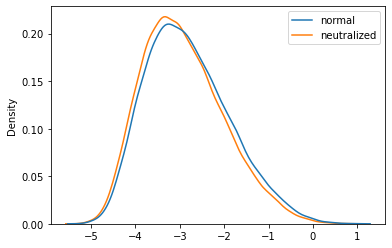

In [81]:
# np.random.seed(123)
# rand_val_idx = np.random.choice(np.arange(len(base_val_preds)), 50_000, replace=False)
sns.kdeplot(
    data=pd.DataFrame(
        {
            "normal": base_val_preds,  # [rand_val_idx],
            "neutralized": base_val_preds_n,  # [rand_val_idx],
        }
    )
);

In [66]:
%%timeit
base_mod.predict(
    xdev, ntree_limit=base_mod.best_ntree_limit,
)

185 µs ± 5.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
%%timeit
neutralize_pred(
    base_mod, xdev, mask=X[dev].isna(), ntree_limit=base_mod.best_ntree_limit
)

358 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
